In [1]:
import strawberryfields as sf
import tensorflow as tf
print(sf.__version__)
print(tf.__version__)

C:\Users\eduardo\Anaconda3\envs\sf_tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\eduardo\Anaconda3\envs\sf_tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\eduardo\Anaconda3\envs\sf_tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\eduardo\Anaconda3\envs

0.10.0
1.3.0


Beginning optimization
Step: 0 Loss: 0.3646063506603241
Step: 100 Loss: 0.035892073065042496
Step: 200 Loss: 0.012392601929605007
Step: 300 Loss: 0.006306431721895933
Step: 400 Loss: 0.0045860279351472855
Step: 500 Loss: 0.00379396160133183
Step: 600 Loss: 0.0033137211576104164
Step: 700 Loss: 0.002988426946103573
Step: 800 Loss: 0.0027570680249482393
Step: 900 Loss: 0.0025887642987072468
Step: 1000 Loss: 0.002465288620442152
Step: 1100 Loss: 0.002374592237174511
Step: 1200 Loss: 0.002307882998138666
Step: 1300 Loss: 0.002258651191368699
Step: 1400 Loss: 0.002222116570919752
Step: 1500 Loss: 0.002194758737459779
Elapsed time is 139.0 seconds


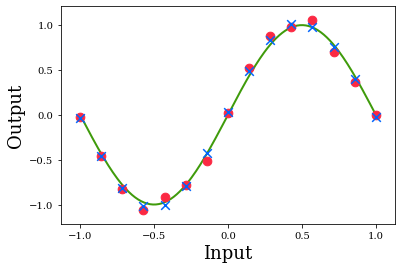

In [2]:
# Copyright 2018 Xanadu Quantum Technologies Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Function fitting script"""
import os
import time

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams

import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *


# ===================================================================================
#                                   Hyperparameters
# ===================================================================================


# Fock basis truncation
cutoff = 10
# domain [-xmax, xmax] to perform the function fitting over
xmax = 1
# Number of batches to use in the optimization
# Each batch corresponds to a different input-output relation
batch_size = 15
# Number of photonic quantum layers
depth = 10

# variable clipping values
disp_clip = 100
sq_clip = 50
kerr_clip = 50

# number of optimization steps
reps = 1500

# regularization
regularization = 0.0
reg_variance = 0.0


# ===================================================================================
#                                   Functions
# ===================================================================================
# This section contains various function we may wish to fit using our quantum
# neural network.


def f1(x, eps=0.0):
    """The function f(x)=|x|+noise"""
    return np.abs(x) + eps * np.random.normal(size=x.shape)


def f2(x, eps=0.0):
    """The function f(x)=sin(pi*x)/(pi*x)+noise"""
    return np.sin(x*pi)/(pi*x) + eps * np.random.normal(size=x.shape)


def f3(x, eps=0.0):
    """The function f(x)=sin(pi*x)+noise"""
    return 1.0*(np.sin(1.0 * x * np.pi) + eps * np.random.normal(size=x.shape))


def f4(x, eps=0.0):
    """The function f(x)=exp(x)+noise"""
    return np.exp(x) + eps * np.random.normal(size=x.shape)


def f5(x, eps=0.0):
    """The function f(x)=tanh(4x)+noise"""
    return np.tanh(4*x) + eps * np.random.normal(size=x.shape)


def f6(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return x**3 + eps * np.random.normal(size=x.shape)


# ===================================================================================
#                                   Training data
# ===================================================================================
# load the training data from the provided files

#train_data = np.load('sine_train_data.npy')
#test_data = np.load('sine_test_data.npy')
#data_y = np.load('sine_outputs.npy')

train_data= np.linspace(-xmax, xmax, batch_size)
data_y=sin(np.pi*train_data)+0.2*np.random.rand(train_data.shape[0])-0.1

test_data=np.linspace(-xmax,xmax,batch_size)

# ===================================================================================
#                      Construct the quantum neural network
# ===================================================================================

# Random initialization of gate parameters
sdev = 0.05

with tf.name_scope('variables'):
    d_r = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    d_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    r1 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    sq_r = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    sq_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    r2 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    kappa1 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))


# construct the one-mode Strawberry Fields engine
eng, q = sf.Engine(1)


def layer(i):
    """This function generates the ith layer of the quantum neural network.
    Note: it must be executed within a Strawberry Fields engine context.
    Args:
        i (int): the layer number.
    """
    with tf.name_scope('layer_{}'.format(i)):
        # displacement gate
        Dgate(tf.clip_by_value(d_r[i], -disp_clip, disp_clip), d_phi[i]) | q[0]
        # rotation gate
        Rgate(r1[i]) | q[0]
        # squeeze gate
        Sgate(tf.clip_by_value(sq_r[i], -sq_clip, sq_clip), sq_phi[i]) | q[0]
        # rotation gate
        Rgate(r2[i]) | q[0]
        # Kerr gate
        Kgate(tf.clip_by_value(kappa1[i], -kerr_clip, kerr_clip)) | q[0]


# Use a TensorFlow placeholder to store the input data
input_data = tf.placeholder(tf.float32, shape=[batch_size])

# construct the circuit
with eng:
    # the input data is encoded as displacement in the phase space
    Dgate(input_data) | q[0]

    for k in range(depth):
        # apply layers to the required depth
        layer(k)

# run the engine
state = eng.run('tf', cutoff_dim=cutoff, eval=False, batch_size=batch_size)


# ===================================================================================
#                      Define the loss function
# ===================================================================================

# First, we calculate the x-quadrature expectation value
ket = state.ket()
mean_x, svd_x = state.quad_expectation(0)
errors_y = tf.sqrt(svd_x)

# the loss function is defined as mean(|<x>[batch_num] - data[batch_num]|^2)
output_data = tf.placeholder(tf.float32, shape=[batch_size])
loss = tf.reduce_mean(tf.abs(mean_x - output_data) ** 2)
var = tf.reduce_mean(errors_y)

# when constructing the cost function, we ensure that the norm of the state
# remains close to 1, and that the variance in the error do not grow.
state_norm = tf.abs(tf.reduce_mean(state.trace()))
cost = loss + regularization * (tf.abs(state_norm - 1) ** 2) + reg_variance*var
tf.summary.scalar('cost', cost)


# ===================================================================================
#                      Perform the optimization
# ===================================================================================

# we choose the Adam optimizer
optimiser = tf.train.AdamOptimizer()
min_op = optimiser.minimize(cost)

session = tf.Session()
session.run(tf.global_variables_initializer())

print('Beginning optimization')

loss_vals = []
error_vals = []

# start time
start_time = time.time()
error_sin=np.zeros(reps+1)
for i in range(reps+1):

    loss_, predictions, errors, mean_error, ket_norm, _ = session.run(
        [loss, mean_x, errors_y, var, state_norm, min_op],
        feed_dict={input_data: train_data, output_data: data_y})

    loss_vals.append(loss_)
    error_vals.append(mean_error)
    
    error_sin[i]=np.sum((f3(test_data)-predictions)**2)/50

    if i % 100 == 0:
        print('Step: {} Loss: {}'.format(i, loss_))

end_time = time.time()


# ===================================================================================
#                      Analyze the results
# ===================================================================================

test_predictions = session.run(mean_x, feed_dict={input_data: test_data})

np.save('sine_test_predictions', test_predictions)

print("Elapsed time is {} seconds".format(np.round(end_time - start_time)))

x = np.linspace(-xmax, xmax, 200)

# set plotting options
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern Roman']

fig, ax = plt.subplots(1,1)

# plot the function to be fitted, in green
ax.plot(x, f3(x), color='#3f9b0b', zorder=1, linewidth=2)

# plot the training data, in red
ax.scatter(train_data, data_y, color='#fb2943', marker='o', zorder=2, s=75)

# plot the test predictions, in blue
ax.scatter(test_data, test_predictions, color='#0165fc', marker='x', zorder=3, s=75)

ax.set_xlabel('Input', fontsize=18)
ax.set_ylabel('Output', fontsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

#fig.savefig('result.pdf', format='pdf', bbox_inches='tight')

In [20]:
#print(loss_vals)
print(i)
print(len(loss_vals))
print(error_sin.shape)

500
501
(501,)


In [3]:
np.save('10layers-overf-15',test_predictions)

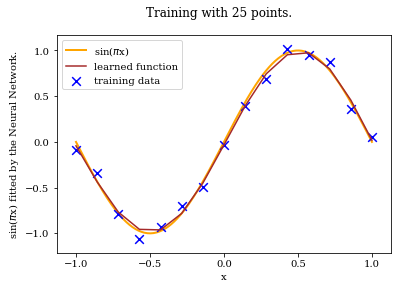

In [5]:
#test_predictions.sort()
#test_data.sort()
test_predictions2=np.load('2layers.npy')
#test_predictions3=np.load('3layers.npy')
test_predictions4=np.load('4layers.npy')
#test_predictions5=np.load('5layers.npy')
test_predictions6=np.load('6layers.npy')
#test_predictions7=np.load('7layers.npy')
test_predictions8=np.load('8layers.npy')
#test_predictions_overf_10=np.load('10layers-overf-15.npy')
# set plotting options
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Computer Modern Roman']

fig, ax = plt.subplots(1,1)

# plot the function to be fitted, in orange
ax.plot(x, f3(x), color='orange', zorder=1, linewidth=2, label='sin($\\pi$x)')

# plot the training data, in red
ax.scatter(train_data, data_y, color='blue', marker='x', zorder=2, s=75, label='training data')

# plot the test predictions, in blue
ax.plot(test_data, test_predictions2, color='grey',label='2 layers')
#ax.plot(test_data, test_predictions3, color='grey',label='3 layers')
ax.plot(test_data, test_predictions4, color='green',label='4 layers')
#ax.plot(test_data, test_predictions5, color='orange',label='5 layers')#, color='#0165fc', marker='x', zorder=3, s=75)
ax.plot(test_data, test_predictions6, color='brown',label='learned function')
#ax.plot(test_data, test_predictions7, color='brown',label='7 layers')
ax.plot(test_data, test_predictions8, color='red',label='8 layers')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('sin($\\pi$x) fitted by the Neural Network.', fontsize=10)
ax.tick_params(axis='both', which='minor', labelsize=16)

plt.legend(loc="upper left") 
fig.suptitle('Training with 25 points.')#, fontsize=15)

fig.savefig('overf10-15.pdf', format='pdf', bbox_inches='tight')

In [6]:
np.save("loss10l-overf",loss_vals)

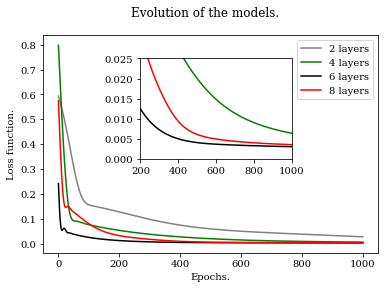

In [16]:
fig, ax = plt.subplots(1,1)

loss2=np.load('loss2l.npy')
loss4=np.load('loss4l.npy')
loss6=np.load('loss6l.npy')
loss8=np.load('loss8l.npy')
#loss10=np.load('loss10l-overf.npy')


ax.plot(loss2, color='grey',label="2 layers")
ax.plot(loss4, color='green',label="4 layers")
ax.plot(loss6, color='black',label="6 layers")
ax.plot(loss8, color='red',label="8 layers")

ax.set_xlabel('Epochs.', fontsize=10)
ax.set_ylabel('Loss function.', fontsize=10)
plt.legend(loc='upper right')
fig.suptitle('Evolution of the models.')#, fontsize=15)

sub_axes = plt.axes([.35, .45, .35, .35])
#sub_axes.xlim(2000,3500)
sub_axes.plot(loss2, color='grey') 
sub_axes.plot(loss4, color='green') 
sub_axes.plot(loss6, color='black')
sub_axes.plot(loss8, color='red')


plt.ylim(0.0,0.025)
plt.xlim(200,1000)

fig.savefig('evolution-architecture-zoom.pdf', format='pdf', bbox_inches='tight')

Text(0.5, 0.98, 'Curve fitting for different number of layers.')

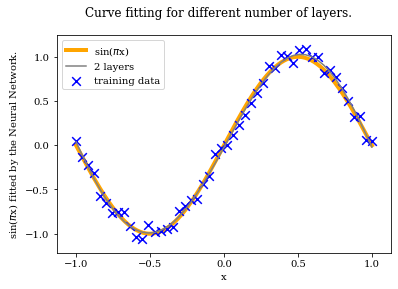

In [4]:
fig, ax = plt.subplots(1,1)
test_predictions8=np.load('8layers-overf.npy')

# plot the function to be fitted, in green
ax.plot(x, f3(x), color='orange', zorder=1, linewidth=4, label='sin($\\pi$x)')

# plot the training data, in red
ax.scatter(train_data, data_y, color='blue', marker='x', zorder=2, s=75, label='training data')

# plot the test predictions, in blue
ax.plot(test_data, test_predictions8, color='grey',label='2 layers')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('sin($\\pi$x) fitted by the Neural Network.', fontsize=10)
ax.tick_params(axis='both', which='minor', labelsize=16)

plt.legend(loc="upper left") 
fig.suptitle('Curve fitting for different number of layers.')#, fontsize=15)

#fig.savefig('architecture.pdf', format='pdf', bbox_inches='tight')

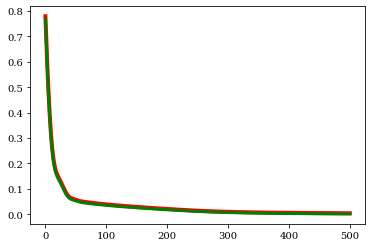

In [36]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_vals, color='red',linewidth=4,label="8 layers")
ax.plot(error_sin, color='green', linewidth=3,label="8 layers")

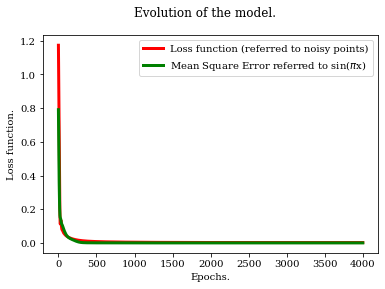

In [43]:
fig, ax = plt.subplots(1,1)
loss10=np.load('loss10l-overf.npy')
#print(loss8.shape)

ax.plot(loss10, color='red', linewidth=3, label="Loss function (referred to noisy points)")
ax.plot(error_sin, color='green', linewidth=3,label="Mean Square Error referred to sin($\\pi$x)")

ax.set_xlabel('Epochs.', fontsize=10)
ax.set_ylabel('Loss function.', fontsize=10)
plt.legend(loc='upper right')
fig.suptitle('Evolution of the model.')#, fontsize=15)

fig.savefig('evolution-overf.png', format='png', bbox_inches='tight')

In [44]:
print(loss_vals[3900])
print(' ')
print(error_sin[3900])

0.0021256383
 
0.0007074553609020862


(2500, 3800)

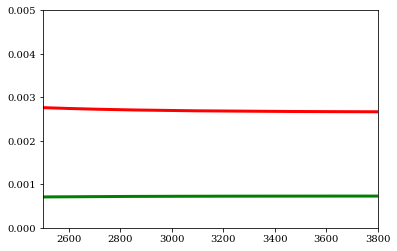

In [49]:
fig, ax = plt.subplots(1,1)
loss10=np.load('loss10l-overf.npy')

ax.plot(loss10, color='red', linewidth=3, label="Loss function (referred to noisy points)")
ax.plot(error_sin, color='green', linewidth=3,label="Mean Square Error referred to sin($\\pi$x)")
plt.ylim(0.0,0.005)
plt.xlim(2500,3800)

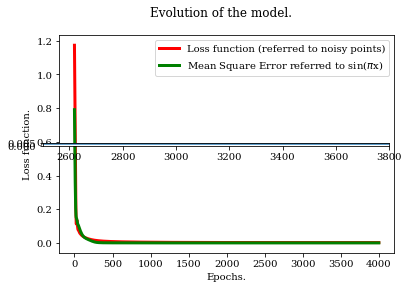

In [66]:
fig, ax = plt.subplots(1,1)
loss10=np.load('loss10l-overf.npy')
#print(loss8.shape)

ax.plot(loss10, color='red', linewidth=3, label="Loss function (referred to noisy points)")
ax.plot(error_sin, color='green', linewidth=3,label="Mean Square Error referred to sin($\\pi$x)")

ax.set_xlabel('Epochs.', fontsize=10)
ax.set_ylabel('Loss function.', fontsize=10)
plt.legend(loc='upper right')
fig.suptitle('Evolution of the model.')#, fontsize=15)

#fig.savefig('evolution-overf.png', format='png', bbox_inches='tight')

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = zoomed_inset_axes(ax, 3.5, loc='right') # zoom-factor: 2.5, location: upper-left

x1, x2, y1, y2 = 2500, 3800, 0.0, 0.005 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

#from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

axins.plot(loss10)


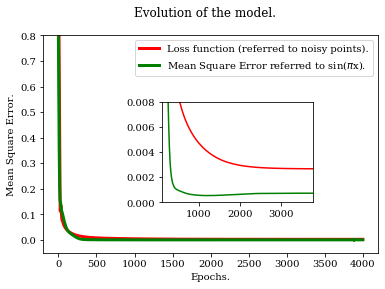

In [83]:
fig, ax = plt.subplots(1,1)

ax.plot(loss10, color='red', linewidth=3, label="Loss function (referred to noisy points).")
ax.plot(error_sin, color='green', linewidth=3,label="Mean Square Error referred to sin($\\pi$x).")

ax.set_xlabel('Epochs.', fontsize=10)
ax.set_ylabel('Mean Square Error.', fontsize=10)
plt.legend(loc='upper right')
plt.ylim(-0.05,0.8)
fig.suptitle('Evolution of the model.')

sub_axes = plt.axes([.4, .3, .35, .35])
#sub_axes.xlim(2000,3500)
sub_axes.plot(loss10, color = 'red') 
sub_axes.plot(error_sin, color = 'green') 
plt.ylim(0.0,0.008)
plt.xlim(100,3800)

fig.savefig('evolution-overf.pdf', format='pdf', bbox_inches='tight')